<a href="https://colab.research.google.com/github/Hjhirp/Hiring-Hoax/blob/main/DSFakeJobPosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS418 Progress Report: Fraudulent Job Post Detection

Github: https://github.com/Hjhirp/Hiring-Hoax


## Project Introduction

In today’s digital hiring landscape, job seekers increasingly rely on online platforms to find employment opportunities. However, this convenience comes with a growing threat—**fraudulent job postings**. These fake listings are designed to deceive applicants, often leading to stolen personal information, financial loss, and wasted time.

This project, titled **“The Hiring Hoax: Separating Real Jobs from Scams,”** aims to develop a robust machine learning-based system to detect suspicious job postings. By analyzing both textual content (like job descriptions, requirements, and titles) and structured metadata (like company profile, employment type, and remote status), we seek to uncover the red flags that are common in scam listings.

### Key Steps in Our Approach:
- **Data Cleaning & Preprocessing** of job listings from a real-world Kaggle dataset
- **Exploratory Data Analysis (EDA)** to identify patterns in fraudulent jobs
- **Feature Engineering** to capture spam-like behaviors, vague content, and missing metadata
- **Hypothesis Testing** to validate common characteristics of scam jobs
- **Model Training & Evaluation** using classifiers such as Random Forest, SVM, Logistic Regression, and XGBoost

**Goal**: Build a reliable classifier that can assist job seekers, employers, and job-board platforms in identifying and filtering out fake job postings.



## Changes Since the Proposal

During our initial proposal, we mentioned our plan to expand the dataset by integrating job posting data through external APIs. This was aimed at supplementing the Kaggle dataset with more recent or diverse job listings to improve the robustness of our model.

### What Changed:
- **Removed**: API-based data collection. We explored using job board APIs but found the process to be time-intensive and constrained by rate limits or access restrictions. Given our project timeline, we chose to prioritize depth of analysis over external data expansion.


### Additions:
- **Enhanced Hypothesis Testing**: We expanded our hypothesis testing section to include statistical validations using Mann-Whitney U and t-tests.
- **Scam-Likeness Score**: We introduced a new composite metric to quantify the likelihood of a job posting being fraudulent, which was not in the original scope.
- **POS Tag Analysis**: Added linguistic-level features to explore syntactic structure differences between real and fake job descriptions.

By focusing on refining our analysis of the existing dataset, we ensured that our project delivers meaningful insights within scope and on time.


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from google.colab import files


# uploaded = files.upload()


### Data Prepration

## Data Preparation

To detect fraudulent job postings effectively, it is critical to first clean, standardize, and engineer meaningful features from the dataset. Below is a detailed explanation of how the data was prepared:

### 1. Loading the Dataset

We loaded the dataset from a CSV file (`fake_job_postings.csv`) and set the `job_id` column as the index. The dataset contains various text, categorical, and binary features related to job postings, with the target variable `fraudulent` indicating whether a job is real (0) or fake (1).

### 2. Handling Missing Values

We assessed the dataset for missing values across all columns. For key text fields such as `title`, `company_profile`, `description`, `requirements`, and `benefits`, we filled missing entries with an empty string (`' '`). For other fields like `location`, `department`, and `salary_range`, we filled in default placeholder values like `'Unknown'` or `'Not Specified'`.

### 3. Text Preprocessing

To prepare textual data for analysis, we applied the following preprocessing steps:
- Converted all text to lowercase
- Removed numerical digits
- Removed stopwords (using NLTK's English stopword list)
- Lemmatized the `description` field using SpaCy

A new combined `text` field was created by concatenating `company_profile`, `description`, `requirements`, and `benefits`.

### 4. Feature Engineering

We created several handcrafted features to capture patterns typically seen in fraudulent job postings:
- **Metadata Completeness**: Flags like `has_no_company_profile`, `has_short_description`, `has_short_requirements`, and `has_incomplete_extra_attributes`
- **Spam Indicators**: Presence of promotional or misleading words (`contains_spamword`), excessive punctuation (`consecutive_punct`), and monetary symbols (`money_in_title`, `money_in_description`)
- **Suspicious Phrasing**: Features such as `external_application`, `url_in_text`, and `addresses_lower_education` detect content prompting users to apply externally or indicating low education requirements
- **Part-of-Speech Analysis**: Using SpaCy, we computed counts of nouns, verbs, adjectives, adverbs, and pronouns in the combined text to understand linguistic differences

### 5. Duplicate Detection and Cleanup

To ensure data integrity:
- We identified and removed duplicate records
- We reported how many of these duplicates were fraudulent
- Finally, the dataset index was reset

### 6. Correlation and Exploratory Checks

To evaluate feature significance:
- A correlation matrix was plotted using the engineered features
- Bar plots were created for each binary feature to visualize the distribution of 0s and 1s
- Part-of-speech features were inspected for their relevance in distinguishing real and fake postings

This cleaned and enriched dataset was then used for hypothesis testing and model training in subsequent steps.


In [ ]:
# read raw data
df = pd.read_csv("fake_job_postings.csv").set_index('job_id')
print("Shape of data: ", df.shape)
df.head()

In [ ]:
print("Null Values across each features")
df.isnull().sum()

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import spacy

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

def preprocess_text(text):
    # text = str(text)
    text = text.lower()
    # text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\d+', '', text)
    # text = re.sub(r'[^\w\s]', '', text)
    # text = re.sub(r'\s+', ' ', text)
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

In [ ]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna(' ')

In [ ]:
fill_values = {
    'location': 'Unknown',
    'department': 'Unknown',
    'salary_range': 'Not Specified',
    # 'employment_type': 'Not Specified',
    # 'required_experience': 'Not Specified',
    # 'required_education': 'Not Specified',
    # 'industry': 'Not Specified',
    # 'function': 'Not Specified'
}
df.fillna(value=fill_values, inplace=True)

In [ ]:
df['text'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

df['text'] = df['text'].apply(preprocess_text)

In [ ]:
from tqdm import tqdm

# Creating a ruleset dataframe based on the unprocessed dataset
df_ruleset = df.copy()


# Function: Presence of Words in String
def are_words_in_field(docs, words):
    contains = []
    for doc in tqdm(docs):
        has_tokens = 0
        for word in words:
            if word.lower() in doc.lower():
                has_tokens = 1
        contains.append(has_tokens)
    return pd.Series(contains)


# Feature: Number of Consecutive Punctuation
def get_consecutive_punctuation(docs):
    counts = []
    for doc in tqdm(docs):
        count = 0
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = list(zip(tokens[1:], tokens))
        for tok in tokens:
            if tok[0] in punctuations and tok[1] in punctuations:
                count += 1
        counts.append(count)
    return pd.Series(counts)


# Function: Get POS Tag
def get_pos_tags(text, tag):
    count = 0
    doc = nlp(text)
    for tok in doc:
        if tok.pos_ != tag:
            continue
        count += 1
    return count


# Extract Feature: No company profile
empty_profiles = []
for profile in df_ruleset['company_profile']:
    if profile == ' ':
        empty_profiles.append(1)
    else:
        empty_profiles.append(0)

df_ruleset['has_no_company_profile'] = pd.Series(empty_profiles)

# Extract Feature: Short Company Profile
short_profiles = []
for desc in tqdm(df_ruleset['company_profile']):
    if len(desc) < 10:
        short_profiles.append(1)
    else:
        short_profiles.append(0)

df_ruleset['has_short_company_profile'] = pd.Series(short_profiles)

# Extract Feature: Has No Long Company Profile
no_long_profiles = []
for desc in tqdm(df_ruleset['company_profile']):
    if 10 < len(desc) < 100:
        no_long_profiles.append(1)
    else:
        no_long_profiles.append(0)

df_ruleset['has_no_long_company_profile'] = pd.Series(no_long_profiles)

# Extract Feature: Has Short Description
short_descriptions = []
for desc in tqdm(df_ruleset['description']):
    if len(desc) < 50:
        short_descriptions.append(1)
    else:
        short_descriptions.append(0)

df_ruleset['has_short_description'] = pd.Series(short_descriptions)

# Extract Feature: Has Short Requirements
short_requirements = []
for desc in tqdm(df_ruleset['requirements']):
    if len(desc) < 10:
        short_requirements.append(1)
    else:
        short_requirements.append(0)

df_ruleset['has_short_requirements'] = pd.Series(short_requirements)

# List of marketing and promotional keywords commonly used in potentially misleading job or money-making ads.
# These terms are grouped from various categories like earnings-related, urgency cues, flexible work phrases,
# vague promises, and attractive offers. Useful for filtering, flagging, or analyzing content for spam detection,
# scam identification, or advertisement classification.
df_ruleset['contains_spamword'] = are_words_in_field(df_ruleset['text'],
                                                     [ "earn", "profit", "money", "commission",
                                                      "bonus", "cash", "reward",
                                                      "immediate", "urgent", "now", "guaranteed",
                                                      "risk‐free", "secure", "work from home", "flexible",
                                                      "home-based", "easy", "simple",
                                                      "effortless", "opportunity", "fast",
                                                      "instant", "once in a lifetime", "extra income",
                                                      "no experience required", "high paying", "unlimited"])

# Extract Feature: Consecutive Punctuation
df_ruleset['consecutive_punct'] = get_consecutive_punctuation(df_ruleset['text'])

# Extract Feature: Has Money Symbols in Title
df_ruleset['money_in_title'] = are_words_in_field(df_ruleset['title'],
                                                  ['$', '$$', '$$$', '€', '€€', '€€€', '£', '££', '£££'])

# Extract Feature: Has Money Symbols in Description
df_ruleset['money_in_description'] = are_words_in_field(df_ruleset['description'],
                                                        ['$', '$$', '$$$', '€', '€€', '€€€', '£', '££', '£££'])



100%|██████████| 6800/6800 [00:00<00:00, 31915.59it/s]


In [ ]:
# Extract Feature: Has URL/Email in Text
df_ruleset['url_in_text'] = are_words_in_field(df_ruleset['text'], ["url", "link", "email", "click", "website",
                                                                  "webpage", "site", "http", "https",
                                                                  "www", "message", "chat", "DM", "follow",
                                                                  "submit", "inquire", "contact"])

# Extract Feature: Prompts for External Application
df_ruleset['external_application'] = are_words_in_field(df_ruleset['text'],
                                                        ["apply now", "register here", "enlist online", "join us",
                                                         "forward CV", "upload CV", "submit CV", "share CV", "dispatch CV",
                                                         "contact us", "reach out", "message us", "call now", "ring now",
                                                         "phone us", "dial us"])

# Extract Feature: Addresses Lower Education
df_ruleset['addresses_lower_education'] = are_words_in_field(df_ruleset['text'], ["high school", "no degree", "no diploma",
                                                                                   "no college", "degree optional", "diploma optional",
                                                                                   "GED accepted", "no education", "basic schooling",
                                                                                   "minimal schooling"])

# Extract Feature: Has Incomplete Extra Attributes
extra_cols = ['industry', 'function', 'employment_type', 'required_education','required_experience']
df_ruleset['has_incomplete_extra_attributes'] = pd.Series(df_ruleset[extra_cols].isna().any(axis=1).astype(int))

100%|██████████| 6800/6800 [00:01<00:00, 4777.53it/s]


In [ ]:
df_no_pos = df_ruleset.copy()
df_no_pos.drop(['description', 'company_profile', 'requirements', 'benefits', 'title', 'department', 'salary_range',
                	'telecommuting',	'has_company_logo',	'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry',
                'function', 'text', 'location'], axis=1, inplace=True)

In [ ]:
df_ruleset.describe()

,telecommuting,has_company_logo,has_questions,fraudulent,has_no_company_profile,has_short_company_profile,has_no_long_company_profile,has_short_description,has_short_requirements,contains_spamword,consecutive_punct,money_in_title,money_in_description,url_in_text,external_application,addresses_lower_education,has_incomplete_extra_attributes
count,6841.000000,6841.000000,6841.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6841.000000
mean,0.044730,0.772694,0.540418,0.046053,0.221784,0.221930,0.049123,0.001170,0.141228,0.903655,2.302193,0.007310,0.107602,0.772661,0.091520,0.071199,0.574477
std,0.206726,0.419122,0.498400,0.209614,0.415477,0.415575,0.216140,0.034182,0.348282,0.295085,4.351536,0.085191,0.309900,0.419144,0.288369,0.257175,0.494458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

In [ ]:
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

df['description'] = df['description'].apply(lemmatize)

In [ ]:
original_count = df.shape[0]
print(f"Total records before removing duplicates: {original_count}")

duplicated_rows = df[df.duplicated(keep=False)]
print(f"\nNumber of fully duplicated records: {duplicated_rows.shape[0]}")

fraudulent_in_duplicates = duplicated_rows[duplicated_rows['fraudulent'] == 1]
print(f"Number of fraudulent records among duplicates: {fraudulent_in_duplicates.shape[0]}")

df = df.drop_duplicates()

df.reset_index(drop=True, inplace=True)

final_count = df.shape[0]
print(f"\nTotal records after removing duplicates: {final_count}")


Total records before removing duplicates: 6841

Number of fully duplicated records: 78
Number of fraudulent records among duplicates: 2

Total records after removing duplicates: 6800


In [ ]:
df.columns.tolist()
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,marketing intern,"US, NY, New York",Marketing,Not Specified,"food, created groundbreaking award-winning coo...","food , fast - grow , james beard award - win o...",experience content management systems major pl...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0.0,"food, created groundbreaking award-winning coo..."
1,customer service - cloud video production,"NZ, , Auckland",Success,Not Specified,"seconds, worlds cloud video production service...",organise - focus - vibrant - awesome!do passio...,expect you:your key responsibility communicate...,get usthrough part seconds team gain:experienc...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0.0,"seconds, worlds cloud video production service..."
2,commissioning machinery assistant (cma),"US, IA, Wever",Unknown,Not Specified,valor services provides workforce solutions me...,"client , locate houston , actively seek experi...",implement pre-commissioning commissioning proc...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0.0,valor services provides workforce solutions me...
3,account executive - washington dc,"US, DC, Washington",Sales,Not Specified,passion improving quality life geography heart...,company : esri – environmental system research...,"education: bachelor’s master’s gis, business a...","culture anything corporate—we collaborative, c...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0.0,passion improving quality life geography heart...
4,bill review manager,"US, FL, Fort Worth",Unknown,Not Specified,spotsource solutions llc global human capital ...,job title : itemization review managerlocation...,qualifications:rn license state texasdiploma b...,full benefits offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0.0,spotsource solutions llc global human capital ...


In [ ]:
df.to_csv("FinalDataset2.csv", index=False) # after preprocessing and feature extraction -  saving the dataset

# Exploratory Data Analysis (EDA)

In this section, we explore the structure and content of job postings to uncover patterns associated with fraudulent listings. By combining basic data inspection with engineered features (e.g., short text, money symbols, spammy phrases), we identify key red flags and behavioral traits that differentiate fake job posts from real ones. Visualizations support our understanding and will inform future modeling steps.

In [ ]:
# Basic Dataset Overview
df.info()
df['fraudulent'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                6800 non-null   object 
 1   location             6800 non-null   object 
 2   department           6800 non-null   object 
 3   salary_range         6800 non-null   object 
 4   company_profile      6800 non-null   object 
 5   description          6800 non-null   object 
 6   requirements         6800 non-null   object 
 7   benefits             6800 non-null   object 
 8   telecommuting        6800 non-null   int64  
 9   has_company_logo     6800 non-null   int64  
 10  has_questions        6800 non-null   int64  
 11  employment_type      5160 non-null   object 
 12  required_experience  4002 non-null   object 
 13  required_education   3690 non-null   object 
 14  industry             4748 non-null   object 
 15  function             4254 non-null   o

,count
fraudulent,
0.0,6485
1.0,314


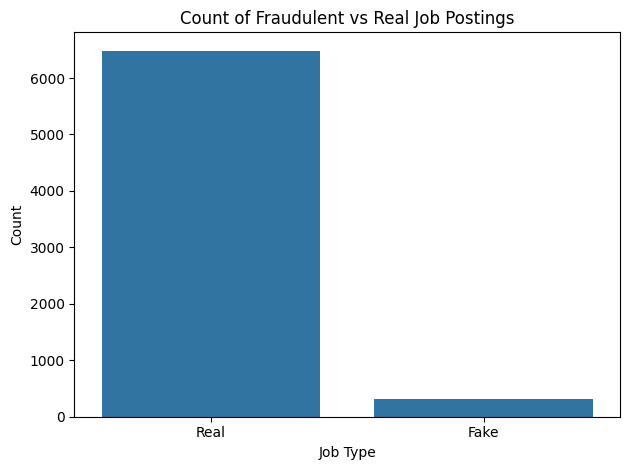

In [ ]:
plt.figure()
sns.countplot(data=df, x='fraudulent')
plt.title("Count of Fraudulent vs Real Job Postings")
plt.xticks([0, 1], ["Real", "Fake"])
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Thoughts :
This shows the overall class balance — fake postings are present but much fewer than real ones, highlighting a class imbalance important for modeling.

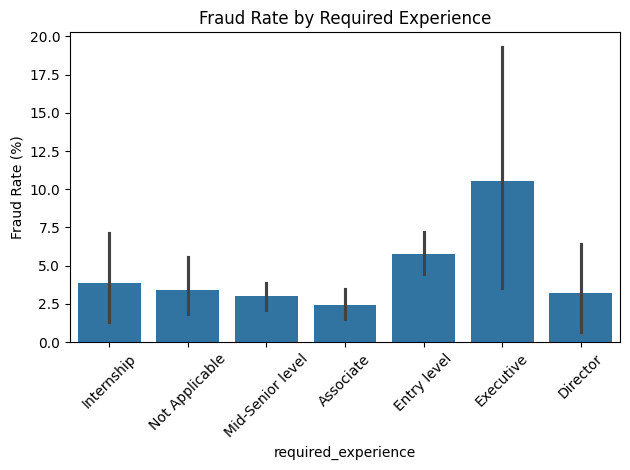

In [ ]:
## Fraud Rate by Required Experience

plt.figure()
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title("Fraud Rate by Required Experience")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Thoughts:
"Internship" and "entry level" roles have much higher fraud rates, confirming the hypothesis that scammers target less experienced applicants.

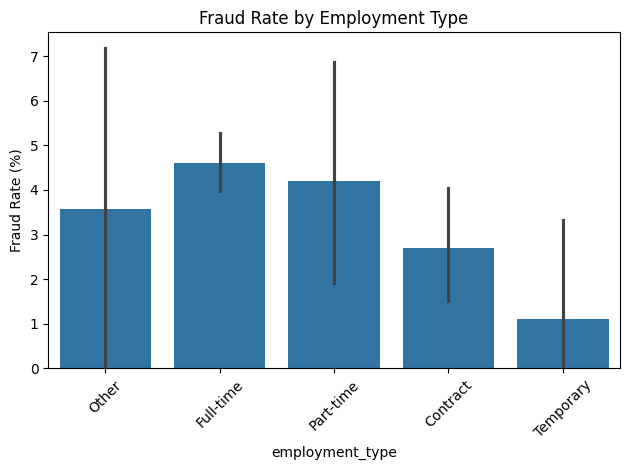

In [ ]:
### Fraud Rate by Employment Type
plt.figure()
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title("Fraud Rate by Employment Type")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Thoughts :
Part-time, contract, and "other" types of employment show a higher fraud rate compared to full-time jobs. This indicates that scams often disguise themselves as flexible or alternative job arrangements.


In [ ]:
# Binary features for engineered insights
df['has_short_description'] = df['description'].apply(lambda x: len(str(x)) < 250)
df['has_short_requirements'] = df['requirements'].apply(lambda x: len(str(x)) < 100)
df['money_in_title'] = df['title'].str.contains(r'\$|€|£', na=False)
df['money_in_description'] = df['description'].str.contains(r'\$|€|£', na=False)
df['url_in_description'] = df['description'].str.contains(r'http[s]?://|www\.', na=False)
df['contains_spamword'] = df['description'].str.contains(r'earn|fast|money|quick|no experience', flags=re.IGNORECASE, na=False)
df['consecutive_punct'] = df['description'].str.contains(r'([!?.,])\1{2,}', na=False)

<ipython-input-24-bb3ef86d451b>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['consecutive_punct'] = df['description'].str.contains(r'([!?.,])\1{2,}', na=False)


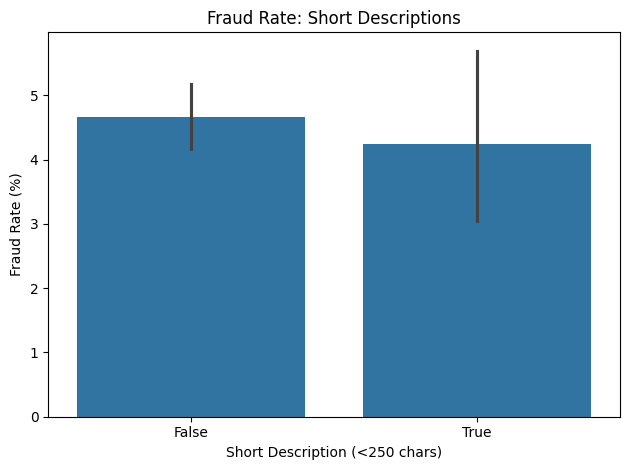

In [ ]:
sns.barplot(data=df, x='has_short_description', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title("Fraud Rate: Short Descriptions")
plt.xlabel("Short Description (<250 chars)")
plt.ylabel("Fraud Rate (%)")
plt.tight_layout()
plt.show()

### Thoughts:
Fake postings are more likely to have **short descriptions**, possibly to reduce effort or mislead users quickly.


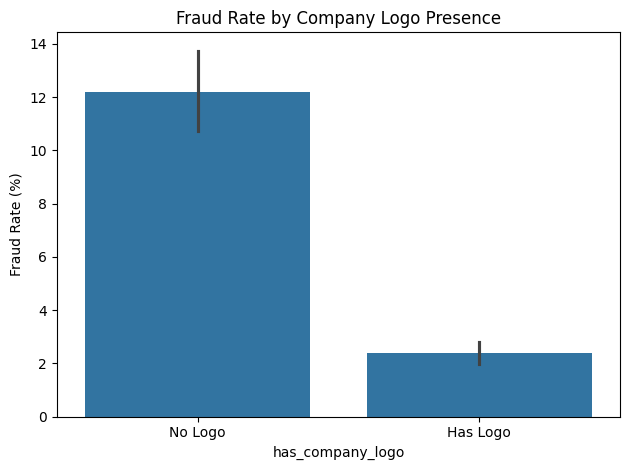

In [ ]:
### Fraud Rate by Company Logo Presence
plt.figure()
sns.barplot(data=df, x='has_company_logo', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title("Fraud Rate by Company Logo Presence")
plt.xticks([0, 1], ["No Logo", "Has Logo"])
plt.ylabel("Fraud Rate (%)")
plt.tight_layout()
plt.show()

### Thoughts:
Fake job postings often omit company logos, suggesting that scammers are less likely to associate their listings with a verifiable entity.

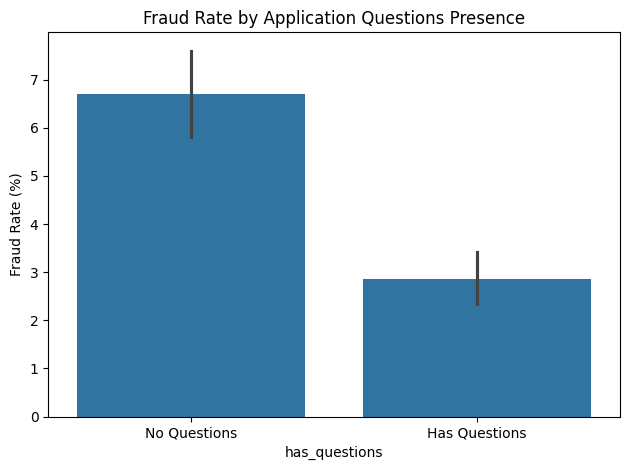

In [ ]:
###  Fraud Rate by Questions Presence

plt.figure()
sns.barplot(data=df, x='has_questions', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title("Fraud Rate by Application Questions Presence")
plt.xticks([0, 1], ["No Questions", "Has Questions"])
plt.ylabel("Fraud Rate (%)")
plt.tight_layout()
plt.show()

### Thoughts:
Legitimate job postings often include questions to screen candidates, while fake listings skip them, likely to attract as many applicants as possible without barriers.

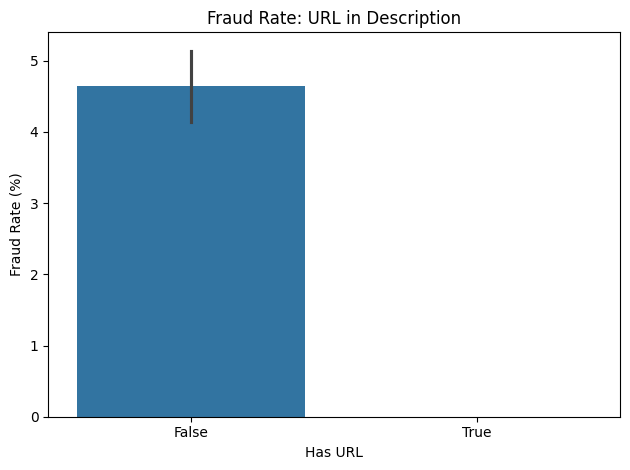

In [ ]:
### Fraud Rate - URLs in Description

sns.barplot(data=df, x='url_in_description', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title("Fraud Rate: URL in Description")
plt.xlabel("Has URL")
plt.ylabel("Fraud Rate (%)")
plt.tight_layout()
plt.show()

### Thoughts:
Interestingly, fake job listings often avoid including **URLs** — possibly because they don’t have legitimate landing pages.

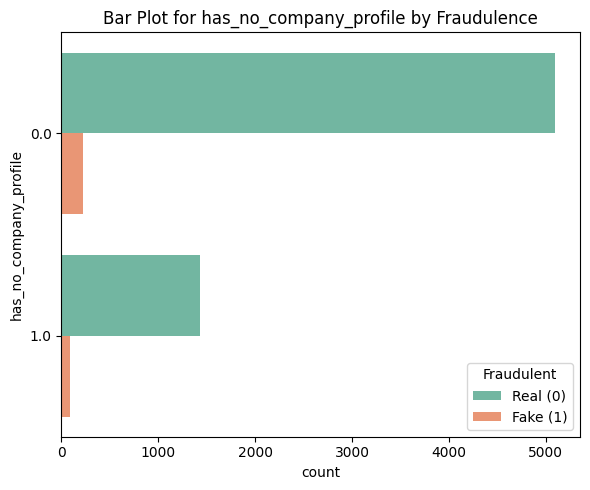

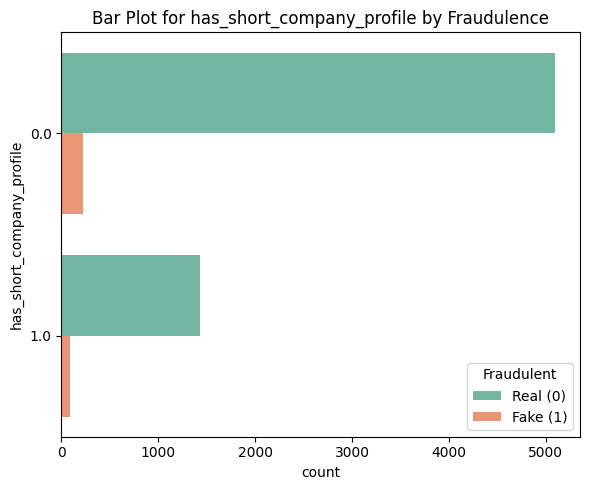

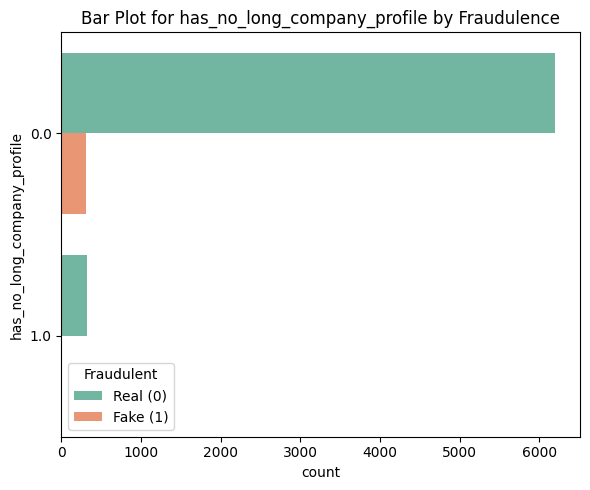

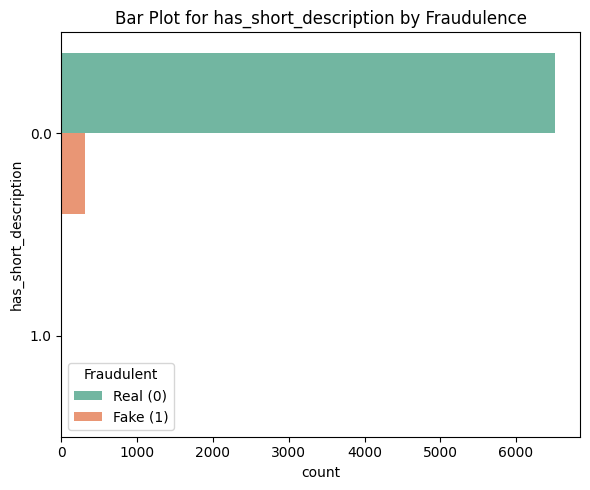

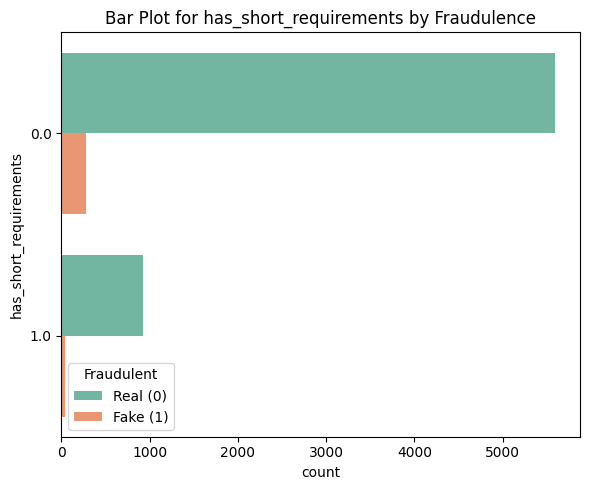

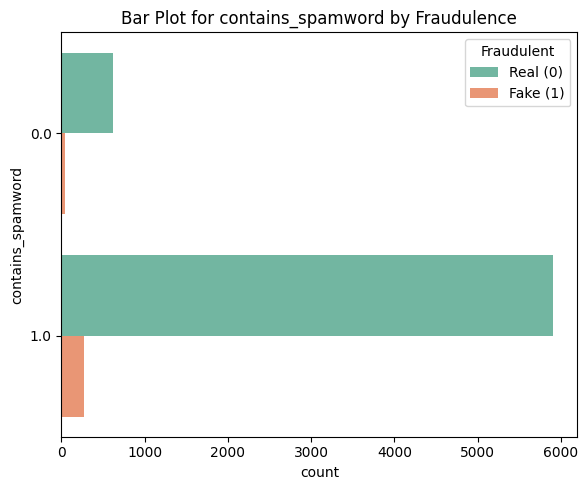

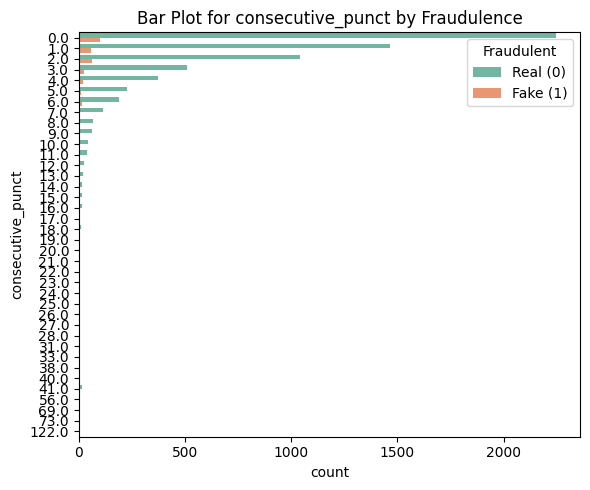

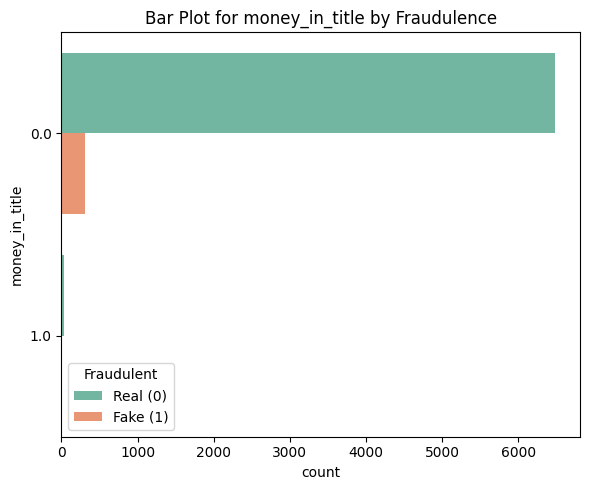

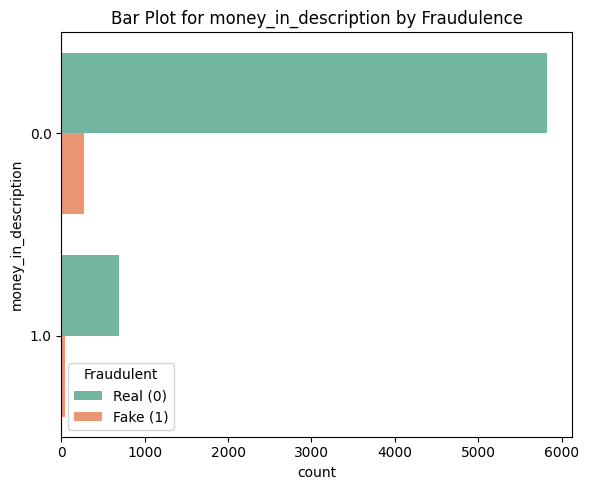

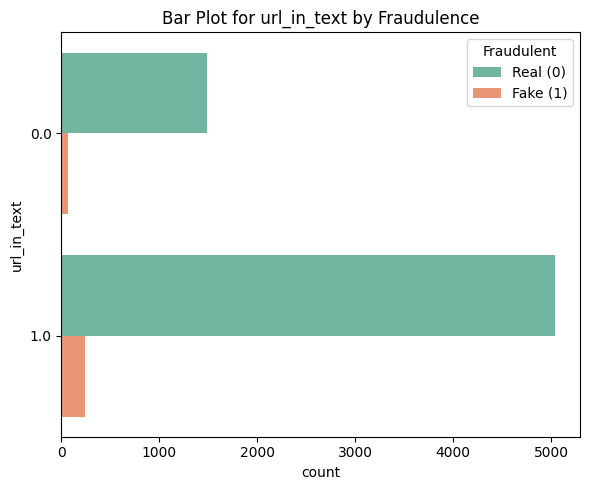

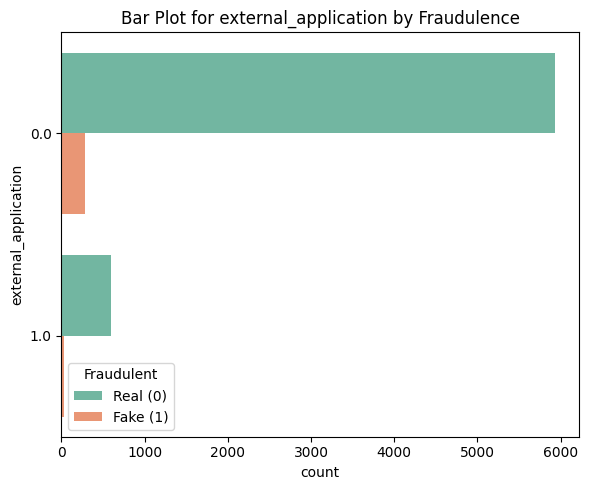

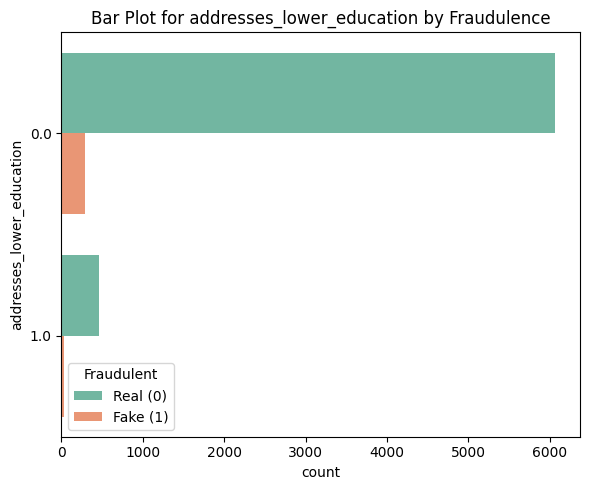

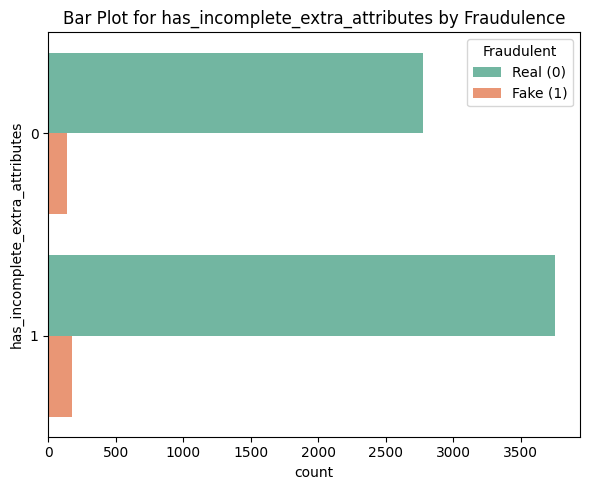

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over each column and plot with hue='fraudulent'
for col in df_no_pos.columns:
    if col == 'fraudulent':
        continue  # Skip the target column itself
    plt.figure(figsize=(6, 5))
    sns.countplot(y=col, hue='fraudulent', data=df_no_pos, palette='Set2')
    plt.title(f'Bar Plot for {col} by Fraudulence')
    plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
    plt.tight_layout()
    plt.show()

### Thoughts:

1. **Company Profile Quality**  
   - Fake posts often lack detailed or complete company profiles.

2. **Description & Requirements**  
   - Short or minimal content may indicate lazy or overly accessible scam attempts.

3. **Promotional Language**  
   - Terms like “earn”, “fast”, and “no experience” are common in fraudulent listings.

4. **External Redirection**  
   - Surprisingly, fake posts rarely contain URLs, possibly due to the lack of legitimate external sites.

5. **Punctuation Use**  
   - Repeated symbols (e.g., “!!!”) are more frequent in scams, suggesting urgency.

6. **Monetary Symbols**  
   - Symbols like $, €, £ are overused in scam titles/descriptions to bait users.

7. **Low Education Targeting**  
   - Phrases like “no degree” suggest scammers often target vulnerable job seekers.

8. **Missing Metadata**  
   - Fields like industry, function, and education are often incomplete in fake listings.


##  Summary
## EDA Key Insight Summaries

1. **Company Profile Quality**  
   Fake job posts often lack detailed or complete company profiles, reducing their legitimacy.

2. **Job Description & Requirements**  
   Scams frequently include minimal or vague descriptions to attract a wider audience.

3. **Promotional Language**  
   The use of clickbait terms like “earn fast” is a strong indicator of fraudulent intent.

4. **External Redirection Techniques**  
   Contrary to expectations, fake listings rarely include external links or applications.

5. **Punctuation Patterns**  
   Overuse of punctuation (e.g., “!!!”) is common in scam listings to simulate urgency.

6. **Monetary Symbols in Content**  
   Fake jobs often use $, €, or £ in titles/descriptions to attract with exaggerated pay.

7. **Targeting Lower-Education Audiences**  
   Scams frequently mention low qualifications like “no degree” to appeal broadly.

8. **Incomplete Metadata**  
   Fraudulent posts often skip fields like industry, function, and education, showing poor structure.

9. **Class Imbalance**  
   Real job posts dominate the dataset, making fraud detection a class imbalance problem.

10. **Experience Level Bias**  
   Entry-level and internship roles have the highest fraud rates, targeting new job seekers.

11. **Risk by Employment Type**  
   Part-time and contract jobs are disproportionately targeted by scammers.

12. **Short Descriptions**  
   Scammers prefer short descriptions to avoid effort and quickly mislead applicants.

13. **Company Logo Absence**  
   Fake listings often omit logos, making them harder to trace or verify.

14. **Lack of Screening Questions**  
   Fraudulent posts usually don’t include screening questions to reduce applicant friction.

15. **Missing URLs**  
   Scams typically avoid placing URLs in the post, likely due to the lack of legitimate links.


In [ ]:

df.to_csv("FinalDataset3.csv", index=False) # after preprocessing and feature extraction


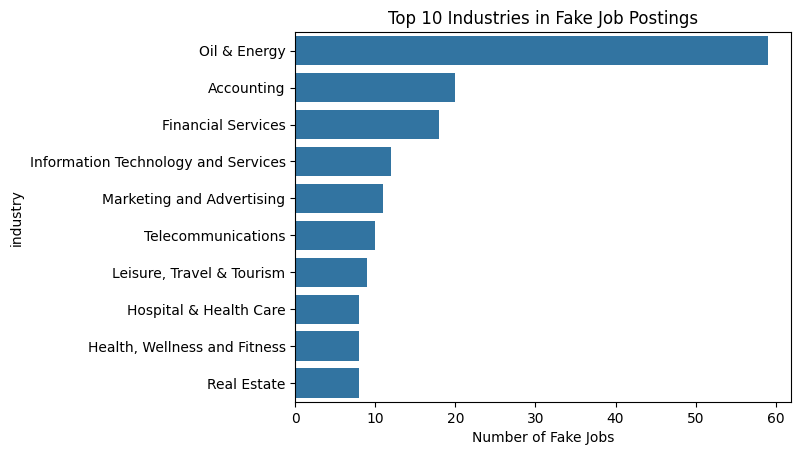

In [ ]:
#Some extra visualizations 1 - Sumanth
sample_df = df.copy()

import matplotlib.pyplot as plt
import seaborn as sns

top_industries = sample_df[sample_df['fraudulent'] == 1]['industry'].value_counts().nlargest(10)
sns.barplot(x=top_industries.values, y=top_industries.index)
plt.title("Top 10 Industries in Fake Job Postings")
plt.xlabel("Number of Fake Jobs")
plt.show()


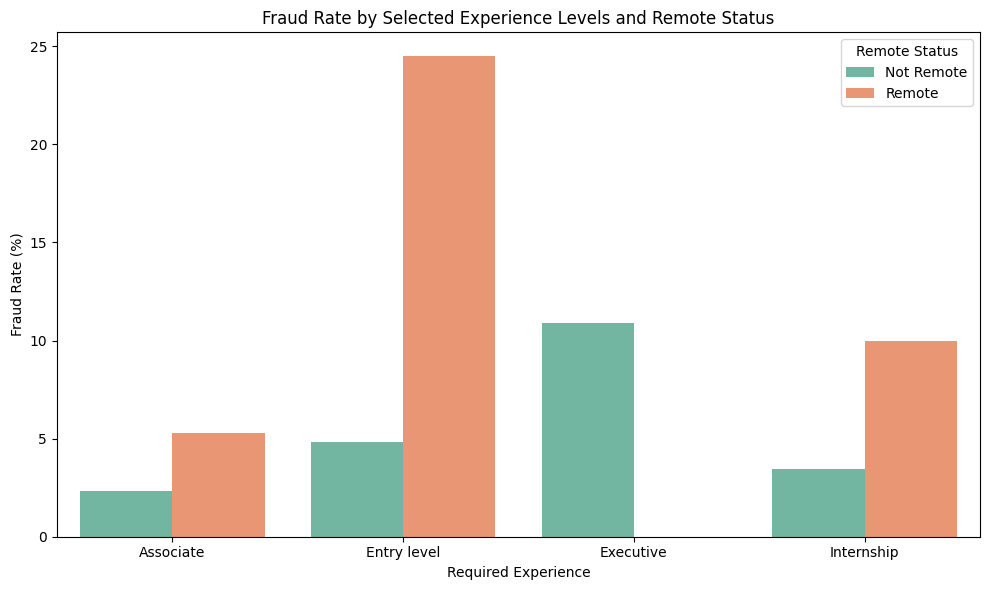

In [ ]:
#Some extra visualizations 2 - Sumanth
def plot_filtered_remote_fraud_experience(df):
    df_temp = df.copy()
    df_temp['telecommuting_label'] = df_temp['telecommuting'].map({0: 'Not Remote', 1: 'Remote'})
    df_temp['required_experience'] = df_temp['required_experience'].fillna('Unknown')

    # Keep only selected experience levels
    selected_levels = ['Entry level', 'Associate', 'Internship', 'Executive']
    df_filtered = df_temp[df_temp['required_experience'].isin(selected_levels)]

    # Group and calculate fraud rate
    grouped = df_filtered.groupby(['required_experience', 'telecommuting_label'])['fraudulent'].mean().reset_index()
    grouped['fraudulent'] *= 100

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped, x='required_experience', y='fraudulent', hue='telecommuting_label', palette='Set2')
    plt.title("Fraud Rate by Selected Experience Levels and Remote Status")
    plt.ylabel("Fraud Rate (%)")
    plt.xlabel("Required Experience")
    plt.xticks(rotation=0)
    plt.legend(title="Remote Status")
    plt.tight_layout()
    plt.show()
plot_filtered_remote_fraud_experience(df)


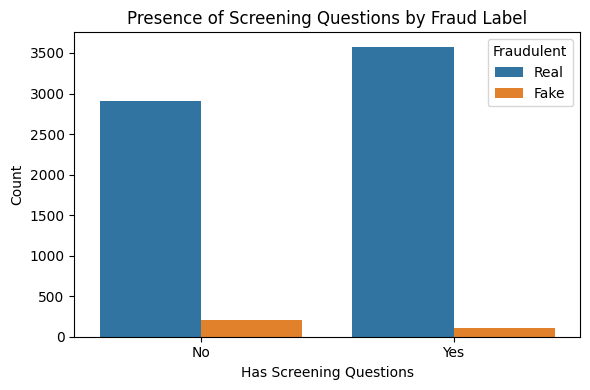

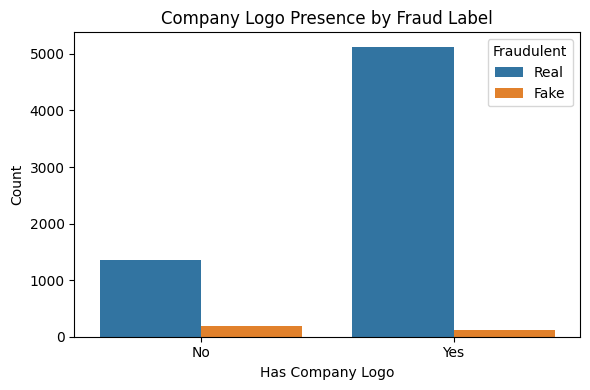

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
#Some extra visualizations 3 - Sumanth

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='has_questions', hue='fraudulent')
plt.title("Presence of Screening Questions by Fraud Label")
plt.xlabel("Has Screening Questions")
plt.xticks([0, 1], ["No", "Yes"])
plt.ylabel("Count")
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.tight_layout()
plt.show()



plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent')
plt.title("Company Logo Presence by Fraud Label")
plt.xlabel("Has Company Logo")
plt.xticks([0, 1], ["No", "Yes"])
plt.ylabel("Count")
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.tight_layout()
plt.show()

# Sample equal number of real and fake jobs
real_jobs = df[df['fraudulent'] == 0].sample(n=500, random_state=42)
fake_jobs = df[df['fraudulent'] == 1].sample(n=500, random_state=42)

# Combine into one DataFrame
balanced_df = pd.concat([real_jobs, fake_jobs])

plt.figure(figsize=(6, 4))
sns.countplot(data=balanced_df, x='has_questions', hue='fraudulent')
plt.title("Screening Questions vs Fraud Label (Balanced Sample)")
plt.xlabel("Has Screening Questions")
plt.xticks([0, 1], ["No", "Yes"])
plt.ylabel("Count")
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.countplot(data=balanced_df, x='has_company_logo', hue='fraudulent')
plt.title("Company Logo Presence vs Fraud Label (Balanced Sample)")
plt.xlabel("Has Company Logo")
plt.xticks([0, 1], ["No", "Yes"])
plt.ylabel("Count")
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.tight_layout()
plt.show()




In [ ]:
#Some extra visualizations 4 - Sumanth

# Ensure text-related columns are string and lowercased for consistency
df['title'] = df['title'].astype(str)
df['description'] = df['description'].astype(str)

# # Create spam_word_count if not present
# if 'spam_word_count' not in df.columns:
#     spam_words = ['earn', 'fast', 'money', 'quick', 'no experience']
#     df['spam_word_count'] = df['description'].apply(
#         lambda x: sum(word in x.lower() for word in spam_words)
#     )


# Create title_length if not present
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))

# Violin plot: Title Length Distribution
sns.violinplot(data=df, x='fraudulent', y='title_length')
plt.title("Title Length Distribution by Fraud Type")
plt.xticks([0, 1], ["Real", "Fake"])
plt.xlabel("Fraudulent")
plt.ylabel("Title Length (words)")
plt.tight_layout()
plt.show()

## Visualization by Harshal

In [ ]:
# Visualization 1 : Bigram
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

EXT_COL = "external_application"
SPAM_COL = "fraudulent"
TEXT_COL = "text"

missing = [c for c in (EXT_COL, SPAM_COL, TEXT_COL) if c not in df_ruleset.columns]
if missing:
    raise KeyError(f"Expected column(s) not in df_ruleset: {missing}")

m_ext = df_ruleset[EXT_COL] == 1
m_spam = df_ruleset[SPAM_COL] == 1

texts = {
    "ext_nonspam":  df_ruleset.loc[m_ext & ~m_spam, TEXT_COL].fillna("").tolist(),
    "ext_spam":     df_ruleset.loc[m_ext &  m_spam, TEXT_COL].fillna("").tolist(),
    "noext_nonspam": df_ruleset.loc[~m_ext & ~m_spam, TEXT_COL].fillna("").tolist(),
    "noext_spam":   df_ruleset.loc[~m_ext &  m_spam, TEXT_COL].fillna("").tolist(),
}

vectorizer = CountVectorizer(stop_words="english", ngram_range=(2, 2), min_df=2).fit(sum(texts.values(), []))

counts = {k: vectorizer.transform(v).sum(axis=0).A1 for k, v in texts.items()}

bigram_df = pd.DataFrame({
    "bigram": vectorizer.get_feature_names_out(),
    "ext_nonspam":   counts["ext_nonspam"],
    "ext_spam":      counts["ext_spam"],
    "noext_nonspam": counts["noext_nonspam"],
    "noext_spam":    counts["noext_spam"],
})

bigram_df = bigram_df[(bigram_df.iloc[:, 1:] > 0).any(axis=1)]

bigram_df["total"] = bigram_df.iloc[:, 1:].sum(axis=1)
top15 = bigram_df.nlargest(15, "total").sort_values("total")

fig, ax = plt.subplots(figsize=(11, 8))
y_pos = np.arange(len(top15))
bar_h = 0.35

ax.barh(y_pos + bar_h / 2, top15["ext_nonspam"], height=bar_h, color="#4C72B0", label="Non‑Spam", edgecolor="white")
ax.barh(y_pos + bar_h / 2, top15["ext_spam"], height=bar_h, left=top15["ext_nonspam"], color="#DD8452", label="Spam", edgecolor="white")
ax.barh(y_pos - bar_h / 2, top15["noext_nonspam"], height=bar_h, color="#4C72B0", edgecolor="white")
ax.barh(y_pos - bar_h / 2, top15["noext_spam"], height=bar_h, left=top15["noext_nonspam"], color="#DD8452", edgecolor="white")

ax.set_yticks(y_pos)
ax.set_yticklabels(top15["bigram"])
ax.invert_yaxis()
ax.set_xlabel("Frequency")
ax.set_title("Bigram Frequency Comparison\nExternal‑Application Asked (top bars) vs No External‑Application Asked (bottom bars)\nColours split by Spam vs Non‑Spam")
ax.legend(title="Label", loc="lower right")
plt.tight_layout()
plt.savefig("bigram_comparison.png")


In [ ]:
# Visualization 2 : Wordcloud
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud

df_ruleset = df.copy()

SPAM_WORDS = [
    "earn", "profit", "money", "commission", "bonus", "cash", "reward",
    "immediate", "urgent", "now", "guaranteed", "risk‑free", "secure",
    "work from home", "flexible", "home-based", "easy", "simple",
    "effortless", "opportunity", "fast", "instant", "once in a lifetime",
    "extra income", "no experience required", "high paying", "unlimited"
]

def count_word_frequencies(docs: pd.Series, vocab: list[str]) -> tuple[pd.Series, Counter]:
    patterns = {w: re.compile(rf"\b{re.escape(w)}\b", re.IGNORECASE) for w in vocab}
    corpus_counter: Counter = Counter()
    per_doc_counts: list[int] = []

    for doc in tqdm(docs, desc="Counting spam‑word frequencies"):
        row_total = 0
        for word, pat in patterns.items():
            n_matches = len(pat.findall(doc))
            if n_matches:
                corpus_counter[word] += n_matches
                row_total += n_matches
        per_doc_counts.append(row_total)

    return pd.Series(per_doc_counts, index=docs.index), corpus_counter

df_ruleset["spamword_freq"], spam_counter = count_word_frequencies(
    df_ruleset["text"], SPAM_WORDS
)

top50 = dict(spam_counter.most_common(50))

wc = WordCloud(width=900, height=450, background_color="white")
wc.generate_from_frequencies(top50)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Top‑50 Spam‑Word Frequencies")
plt.tight_layout()
plt.savefig("spam_wordcloud.png")

top50_df = pd.DataFrame(top50.items(), columns=["word", "frequency"])
print(top50_df.to_string(index=False))

In [ ]:
# Visualization 3 : Heatmap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

FLAG_COL = "addresses_lower_education"
SPAM_COL = "fraudulent"
TEXT_COL = "text"
TOP_N = 20
MIN_COUNT = 3

mask_flag = df_ruleset[FLAG_COL] == 1
texts_spam = df_ruleset.loc[mask_flag & (df_ruleset[SPAM_COL] == 1), TEXT_COL].fillna("").tolist()
texts_nonspam = df_ruleset.loc[mask_flag & (df_ruleset[SPAM_COL] == 0), TEXT_COL].fillna("").tolist()

vectorizer = CountVectorizer(stop_words="english", ngram_range=(1, 1), min_df=2)
vectorizer.fit(texts_spam + texts_nonspam)

spam_counts = vectorizer.transform(texts_spam).sum(axis=0).A1.astype(int)
nonspam_counts = vectorizer.transform(texts_nonspam).sum(axis=0).A1.astype(int)
words = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({"word": words, "Spam": spam_counts, "Non‑Spam": nonspam_counts})
freq_df["total"] = freq_df["Spam"] + freq_df["Non‑Spam"]
freq_df = freq_df[freq_df["total"] >= MIN_COUNT]

heat_df = (
    freq_df.nlargest(TOP_N, "total")
    .set_index("word")[["Non‑Spam", "Spam"]]
    .sort_values("Spam")
)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    heat_df,
    cmap="YlGnBu",
    annot=True,
    fmt="d",
    linewidths=.4,
    cbar_kws={"label": "Token frequency within subset"},
    ax=ax
)

ax.set_title(f"Token Counts (Top‑{TOP_N} words, ads flagged '{FLAG_COL}')")
ax.set_xlabel("Class")
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("heatmap.png")


In [ ]:
# Additional Visualization 4 : Scatterplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

freq = top20.copy()
freq["log_odds"] = np.log((freq["Spam"] + 0.5) / (freq["Non‑Spam"] + 0.5))

sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=freq,
    x="log_odds",
    y="word",
    size="total",
    sizes=(50, 1000),
    hue="log_odds",
    palette=sns.diverging_palette(15, 245, as_cmap=True, center="light"),
    edgecolor="black",
    alpha=0.8,
    ax=ax,
    legend=False
)

ax.axvline(-2, ls="--", lw=1, color="grey")
ax.set_title("Log‑Odds of Unigrams in URL/Email Ads\n(warm = spam‑leaning, cool = non‑spam‑leaning)")
ax.set_xlabel("Log‑Odds Ratio (Spam / Non‑Spam)")
ax.set_ylabel("Word")

plt.tight_layout()
plt.savefig("logodds.png")


## Hypothesis 1: Fake job postings are more likely to have incomplete or vague descriptions and company profiles.

**Member**: Surya Reddy Nallamilli

### Why This Hypothesis?
One of the most common traits of scam job listings is the lack of detailed or credible information. Fraudulent postings often:
- Skip writing a proper company profile
- Omit important job details (like requirements or benefits)
- Overuse vague or enticing language (e.g., "quick hire", "no experience", "apply now")
- Ask for CVs directly via email or links

We hypothesize that these incomplete and vague descriptions can be quantified and statistically linked to fraudulent behavior.
:

### Visualizations
We plotted:
- **Bar plots** for binary features (like presence of website, CV request)
- **Boxplots** and **histograms** for numeric features (like description length)
to observe distribution differences between fraudulent and real job posts.

The results clearly showed that:
- Fraudulent postings more often lack company profiles and have fewer words in descriptions.
- Scam jobs frequently request CV submissions directly.
- Missing critical fields (like requirements/benefits) was more prevalent among fraudulent jobs.

### Statistical Testing
To validate our hypothesis, we used:
- **Mann-Whitney U Test** to compare distributions of features between real and fake jobs.
- **T-test** on a custom-built `scam_likeness_score` — a composite score based on normalized suspicious features.

#### Mann-Whitney U Test Result
Most features (including `has_company_profile`, `cv_request`, and `description_length`) showed **statistically significant differences** (p-value < 0.05) between real and fake job posts.

#### Scam-Likeness Score
We computed a normalized score where higher values represent more scam-like behavior. A t-test confirmed that this score is **significantly higher** for fraudulent listings than for real ones (p-value << 0.05), reinforcing our hypothesis.

### Conclusion
This hypothesis is supported both visually and statistically. Fraudulent job postings are measurably more vague, less informative, and often use suspicious prompting language. These patterns can serve as strong predictive features for identifying scams.


In [ ]:
df_clean = df.copy()

text_columns = ['company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    df_clean[col] = df_clean[col].astype(str).str.lower().str.strip()


df_clean['has_company_profile'] = df_clean['company_profile'].apply(lambda x: 0 if x in ['nan', ''] else 1)
df_clean['company_profile_length'] = df_clean['company_profile'].apply(lambda x: len(x.split()) if x != 'nan' else 0)
df_clean['has_website_in_profile'] = df_clean['company_profile'].apply(lambda x: 1 if re.search(r'https?://', x) else 0)

generic_keywords = [
    'great opportunity', 'quick hire', 'no experience', 'work from home',
    'easy job', 'urgent need', 'flexible hours', 'limited openings'
]

contact_phrases = [
    'contact us', 'apply now', 'reach out', 'email your cv', 'send your resume',
    'get in touch', 'respond immediately', 'available now'
]

generic_pattern = re.compile('|'.join(generic_keywords), re.IGNORECASE)
contact_pattern = re.compile('|'.join(contact_phrases), re.IGNORECASE)

df_clean['num_generic_words'] = df_clean['description'].apply(
    lambda x: len(generic_pattern.findall(x)) if x != 'nan' else 0
)

df_clean['num_contact_phrases'] = df_clean['description'].apply(
    lambda x: len(contact_pattern.findall(x)) if x != 'nan' else 0
)


cv_keywords = ['send.*cv', 'email.*resume', 'attach.*cv', 'provide.*cv', 'submit.*resume']
cv_pattern = re.compile('|'.join(cv_keywords), re.IGNORECASE)
df_clean['cv_request'] = df_clean['description'].apply(lambda x: 1 if cv_pattern.search(x) else 0)

df_clean['description_length'] = df_clean['description'].apply(lambda x: len(x.split()) if x != 'nan' else 0)

critical_fields = ['company_profile', 'benefits', 'requirements']
df_clean['missing_critical_info'] = df_clean[critical_fields].apply(
    lambda row: sum(1 for val in row if val in ['nan', '']), axis=1
)


features = [
    'has_company_profile',
    'company_profile_length',
    'has_website_in_profile',
    'cv_request',
    'description_length',
    'missing_critical_info',
    'fraudulent'  # target variable
]

df_features = df_clean[features]

In [ ]:
df_features.describe()

In [ ]:
sns.set(style="whitegrid")

df_vis = df_clean[features]

binary_features = ['has_company_profile', 'has_website_in_profile', 'cv_request']
numeric_features = ['company_profile_length', 'description_length', 'missing_critical_info']

for feature in binary_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_vis, x=feature, hue='fraudulent')
    plt.title(f"{feature} by Fraudulent Label")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title='Fraudulent')
    plt.tight_layout()
    plt.show()

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_vis, x='fraudulent', y=feature)
    plt.title(f"{feature} Distribution by Fraudulent Label")
    plt.xlabel("Fraudulent")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_vis, x=feature, hue='fraudulent', bins=30, kde=True, element='step', stat='density')
    plt.title(f"{feature} Histogram by Fraudulent Label")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

real = df_clean[df_clean['fraudulent'] == 0]
fake = df_clean[df_clean['fraudulent'] == 1]

alpha = 0.05
test_results = []

for feature in features:
    stat, p = mannwhitneyu(real[feature], fake[feature], alternative='two-sided')
    reject_null = p < alpha
    test_results.append({
        'feature': feature,
        'U_statistic': stat,
        'p_value': p,
        'alpha': alpha,
        'reject_null': reject_null,
        'interpretation': "Reject H₀" if reject_null else "Fail to Reject H₀"
    })

results_df = pd.DataFrame(test_results)

print("Mann-Whitney U Test Hypothesis Evaluation:\n")
print(results_df[['feature', 'p_value', 'alpha', 'interpretation']])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean[features]), columns=features)


df_scaled['scam_likeness_score'] = (
    (1 - df_scaled['has_company_profile']) +
    (1 - df_scaled['has_website_in_profile']) +
    df_scaled['cv_request'] +
    (1 - df_scaled['company_profile_length']) +
    df_scaled['missing_critical_info'] +
    (1 - df_scaled['description_length'])
) / 6

df_scaled['fraudulent'] = df_clean['fraudulent'].values

In [ ]:
from scipy.stats import ttest_ind

real_scores = df_scaled[df_scaled['fraudulent'] == 0]['scam_likeness_score']
fake_scores = df_scaled[df_scaled['fraudulent'] == 1]['scam_likeness_score']

t_stat, p_value = ttest_ind(fake_scores, real_scores, equal_var=False)

t_stat, p_value

In [ ]:
# Visualization 1

plt.figure(figsize=(10, 8))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
# Visualization 2

sns.pairplot(df_features, hue='fraudulent', vars=numeric_features)
plt.suptitle("Pairplot of Numeric Features by Fraudulent Label", y=1.02)
plt.show()


In [ ]:
# Visualization 3

for feature in binary_features:
    counts = df_vis.groupby(feature)['fraudulent'].value_counts().unstack()
    counts.plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(8, 4), legend=True)
    plt.title(f"{feature} Distribution Pie Chart by Fraudulent Label")
    plt.ylabel('')
    plt.show()


In [ ]:
# Visualization 4

from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize=(8,5))
for label, group in df_scaled.groupby('fraudulent'):
    ecdf = ECDF(group['scam_likeness_score'])
    plt.plot(ecdf.x, ecdf.y, label=f"Fraudulent={label}")

plt.xlabel('Scam Likeness Score')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Scam Likeness Score by Fraudulent Label')
plt.legend()
plt.show()


# Hypothesis - 2:

***By: Naga Sumanth Choudary Movva***
<br><br>


***Null Hypothesis (H₀):***
There is no significant difference in the presence of screening questions between real and fake job postings.

***Alternative Hypothesis (H₁):***
Fake job postings are significantly less likely to include screening questions compared to real job postings.

<br>

***Why is this interesting ?***

Screening questions are a standard part of legitimate hiring processes. They help employers assess candidate suitability and demonstrate a structured, intentional approach to recruitment. In contrast, fake job postings are typically designed to attract as many applicants as possible with minimal effort. By skipping screening questions, scammers reduce friction and increase the chances of engagement. This difference in behavior makes the presence or absence of screening questions a meaningful indicator of authenticity.
<br><br><br>

***Visualization***

A bar plot was created using a balanced sample of 500 real and 500 fake job postings to compare the presence of screening questions.
The plot showed that:

Real job postings frequently include screening questions.

Fake postings often skip them, aligning with the pattern of low-effort, high-volume scam behavior.
<br><br><br>

***Statistical Testing***

A Mann-Whitney U test was conducted to evaluate whether the presence of screening questions significantly differs between real and fake job postings.
The test produced a U statistic of 8,656,156 and a p-value of 1.11 × 10⁻³³, indicating a highly significant difference.
This result confirms that fake job posts are significantly less likely to include screening questions.
<br><br><br>

***Conclusion***

This hypothesis is well-supported through both visual and statistical analysis. The absence of screening questions is a consistent and measurable pattern in fraudulent job postings, making it a strong and interpretable feature for scam detection.

<br><br>


---

<br>

Null Hypothesis (H₀):
There is no significant difference in the presence of a company logo between real and fake job postings.

Alternative Hypothesis (H₁):
Fake job postings are significantly less likely to include a company logo compared to real job postings.


<br><br>

***Why this is interesting?***

A company logo is one of the simplest visual indicators of legitimacy. Real employers use logos to build trust, reinforce their brand, and establish a professional presence. Including a logo also gives applicants a way to visually verify the company's identity. Fake job postings, on the other hand, often avoid logos — either because they are not tied to a real organization or to reduce traceability. This absence may reflect a deliberate attempt to appear generic and untraceable, making it a useful signal when assessing authenticity.
<br><br>

***Visualization***

A bar plot was created using a balanced sample of 500 real and 500 fake job postings to compare the has_company_logo feature.
The plot revealed that:

Real job postings almost always include a company logo.

Fake job postings frequently omit logos, aligning with the idea that scammers avoid sharing identifying information.
<br><br>

***Statistical Testing***

A Mann-Whitney U test was performed to assess whether the presence of a company logo significantly differs between real and fake job postings.
The test yielded a U statistic of 10,629,944 and a p-value of 5.81 × 10⁻²⁶⁰, indicating a highly significant difference.
This confirms that fake job posts are measurably less likely to include a company logo, further supporting the hypothesis.
<br><br>

***Conclusion***

This hypothesis is strongly supported by both visualization and statistical evidence. The absence of a company logo is a clear and consistent pattern among fake job listings, making it a reliable feature for identifying scams.



In [ ]:


# Plot 1: Screening questions vs fraud
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='has_questions', hue='fraudulent', palette='coolwarm')
plt.title("Presence of Screening Questions vs Fraudulent Label")
plt.xlabel("Has Screening Questions (0 = No, 1 = Yes)")
plt.ylabel("Number of Job Postings")
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

# Plot 2: Company logo vs fraud
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='coolwarm')
plt.title("Presence of Company Logo vs Fraudulent Label")
plt.xlabel("Has Company Logo (0 = No, 1 = Yes)")
plt.ylabel("Number of Job Postings")
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

In [ ]:
# Mann-Whitney for Hypothesis 2a
real = df[df['fraudulent'] == 0]['has_questions']
fake = df[df['fraudulent'] == 1]['has_questions']

stat, p_value = mannwhitneyu(real, fake, alternative='two-sided')

print("Mann-Whitney U statistic:", stat)
print("p-value:", p_value)

In [ ]:
# Mann-Whitney for Hypothesis 2b
real_logo = df[df['fraudulent'] == 0]['has_company_logo']
fake_logo = df[df['fraudulent'] == 1]['has_company_logo']


stat_logo, p_value_logo = mannwhitneyu(real_logo, fake_logo, alternative='two-sided')

print("Mann-Whitney U statistic:", stat_logo)
print("p-value:", p_value_logo)

In [ ]:
# Sample 500 from each class (real: 0, fake: 1)
real_sample = df[df['fraudulent'] == 0].sample(n=500, random_state=42)
fake_sample = df[df['fraudulent'] == 1].sample(n=500, random_state=42)
sample_df = pd.concat([real_sample, fake_sample])

# Hypothesis 2a. Plot: Screening Questions vs Fraudulent
# plt.figure(figsize=(6, 5))
# sns.countplot(data=sample_df, x='has_questions', hue='fraudulent', palette='coolwarm')
# plt.title("Screening Questions vs Fraudulent (Balanced Sample)")
# plt.xlabel("Has Screening Questions (0 = No, 1 = Yes)")
# plt.ylabel("Number of Job Postings")
# plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
# plt.tight_layout()
# plt.show()

# Hypothesis 2b. Plot: Company Logo vs Fraudulent
plt.figure(figsize=(6, 5))
sns.countplot(data=sample_df, x='has_company_logo', hue='fraudulent', palette='coolwarm')
plt.title("Company Logo Presence vs Fraudulent (Balanced Sample)")
plt.xlabel("Has Company Logo (0 = No, 1 = Yes)")
plt.ylabel("Number of Job Postings")
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

## Hypothesis 3: Fake job postings tend to have shorter or more generic descriptions compared to real ones.

**Member Responsible**: Thanmayi Akkala

Null Hypothesis (H₀):
There is no significant difference in the description length or generic language use between real and fake job postings.

Alternate Hypothesis (H₁):
Fake job postings tend to have shorter or more generic descriptions compared to real ones.

Why this Hypothesis is Interesting:

Fake job postings are often created quickly, either to gather personal information or for other malicious intents. As a result, they tend to avoid effortful or elaborate job descriptions and instead use vague or generic wording. Investigating the patterns in description length and word usage could provide strong indicators to distinguish real and fake postings.



In [ ]:
import re

df['description'] = df['description'].astype(str).str.lower().str.strip()

df = df[df['description'].notna() & (df['description'] != '')]

df['description_length'] = df['description'].apply(lambda x: len(x.split()))

# Generic keywords that scammers often use
genericc_keywords = [
    'easy job', 'no experience', 'work from home', 'quick money',
    'start immediately', 'limited spots', 'apply now', 'click here'
]
pattern = re.compile('|'.join(genericc_keywords))

# Count of generic keywords
df['num_generic_phrases'] = df['description'].apply(lambda x: len(pattern.findall(x)))


In [ ]:
sns.violinplot(data=df, x='fraudulent', y='description_length', inner='quartile')
plt.title("Description Length Distribution by Fraudulent Label")
plt.xlabel("Fraudulent (0 = Real, 1 = Fake)")
plt.ylabel("Description Length")
plt.show()
sns.histplot(data=df[df['fraudulent'] == 0], x='description_length', kde=True, bins=40, stat='density', element='step', label='Real (0)')
sns.histplot(data=df[df['fraudulent'] == 1], x='description_length', kde=True, bins=40, stat='density', element='step', label='Fake (1)')
plt.legend(title='Fraudulent')
plt.title("Description Length Distribution by Fraudulent Label")
plt.xlabel("Description Length")
plt.ylabel("Density")
plt.show()

phrase_counts = df.groupby(['fraudulent', 'num_generic_phrases']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=phrase_counts, x='num_generic_phrases', y='count', hue='fraudulent')
plt.title("Generic Phrase Count in Real vs Fake Job Descriptions")
plt.xlabel("Number of Generic Phrases in a Job Description")
plt.ylabel("Number of Job Postings")
plt.legend(title="Fraudulent (0 = Real, 1 = Fake)")
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame with 'required_experience', 'employment_type', and 'fraudulent'

# --- Data Preparation ---
# Handle potential NaN or empty values if necessary
df['required_experience'] = df['required_experience'].fillna('Not Specified')
df['employment_type'] = df['employment_type'].fillna('Not Specified')

# Calculate the fraud rate for each combination
# Group by the two features and calculate the mean of 'fraudulent' (which is the fraud rate)
fraud_rate_pivot = pd.pivot_table(df,
                                  values='fraudulent',
                                  index='required_experience',
                                  columns='employment_type',
                                  aggfunc=np.mean) # Use mean for rate (fraction of 1s)

# Optional: Fill combinations with no data with 0 or NaN if preferred
fraud_rate_pivot = fraud_rate_pivot.fillna(0)

# --- Plotting the Heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(fraud_rate_pivot,
            annot=True,        # Show the fraud rate values on the cells
            fmt=".1%",         # Format annotations as percentages
            cmap="coolwarm",   # Choose a diverging colormap (e.g., coolwarm, RdYlGn)
            linewidths=.5,     # Add lines between cells
            linecolor='lightgrey' # Color for the lines
           )
plt.title('Fraud Rate (%) by Required Experience and Employment Type', fontsize=14)
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Required Experience', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# You can adapt this code to explore interactions between other pairs of categorical features,
# like 'industry' vs 'function', or 'required_education' vs 'required_experience'.

In [ ]:
real = df[df['fraudulent'] == 0]
fake = df[df['fraudulent'] == 1]

# Description length
stat_len, p_len = mannwhitneyu(real['description_length'], fake['description_length'], alternative='two-sided')

# Generic phrase count
stat_gen, p_gen = mannwhitneyu(real['num_generic_phrases'], fake['num_generic_phrases'], alternative='two-sided')

print(f"Description Length → U: {stat_len:.2f}, p-value: {p_len:.4e} {'→ Reject H₀' if p_len < 0.05 else '→ Fail to Reject H₀'}")
print(f"Generic Phrase Count → U: {stat_gen:.2f}, p-value: {p_gen:.4e} {'→ Reject H₀' if p_gen < 0.05 else '→ Fail to Reject H₀'}")


These plots illustrate the difference in job description length between real and fake job postings:

The violin plot shows the distribution of description lengths. It highlights that fake postings (1) are more concentrated around shorter descriptions, while real postings (0) have a broader spread with longer, more detailed descriptions.

The histogram with KDE overlay reinforces this finding — real job descriptions dominate in higher word counts, whereas fake job descriptions peak earlier and decline sharply. This supports our hypothesis that fake jobs tend to be less descriptive.

Both visualizations strongly align with the results from our Mann-Whitney U test, where the null hypothesis was rejected, confirming a statistically significant difference between the two groups.



# Hypothesis 4:
### By Harshal Hirpara

## Null Hypothesis (H₀):
There is no significant difference in the use of external application links between fake and non-fake job descriptions.

## Alternative Hypothesis (H₁):
Fake job descriptions are more likely to not include external application links compared to non-fake ones.

## Why is this interesting?
Fake job postings often do not include external application links or URLs because scammers typically lack legitimate websites or official platforms to redirect applicants to. Instead, they may rely on vague instructions or direct messaging to collect information. Recognizing the absence of valid external links as a potential red flag can help improve fraud detection systems and better protect job seekers.

## Visualization

### Count Plot with Hue:
This plot shows the count of job posts with and without external_application links, split by real vs fake labels.


### Point Plot:
This visualization shows the mean proportion of posts with external_application links by fraudulence type.


## Statistical Testing

### Mann-Whitney U-test
Non-parametric test for comparing two independent groups when data may not be normally distributed.

## Conclusion
Based on the Mann-Whitney U test, the p-value was found to be less than 0.05, leading us to reject the null hypothesis. This indicates a statistically significant difference in the use of external application links between fake and real job postings.

Also the plots suggest that fraudulent postings may avoid using external links because scammers typically lack legitimate websites to redirect applicants to. Recognizing this absence of external links can provide a useful signal for identifying potentially fake job listings and enhancing the accuracy of fraud detection systems.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization 1

plt.figure(figsize=(7, 5))
sns.countplot(x='external_application', hue='fraudulent', data=df_ruleset, palette='Set2')

plt.title('External Application Usage by Fraudulence')
plt.xlabel('External Application (0 = No, 1 = Yes)')
plt.ylabel('Number of Job Posts')
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.xticks([0, 1], ['No External Link', 'Has External Link'])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

# Visualization 2
plt.figure(figsize=(7, 5))
sns.pointplot(x='fraudulent', y='external_application', data=df_ruleset,
              palette='Set1', capsize=0.1)

plt.title('Proportion of External Application Usage by Fraudulence')
plt.xlabel('Fraudulent (0 = Real, 1 = Fake)')
plt.ylabel('Proportion with External Application')
plt.ylim(0, 1)
plt.xticks([0, 1], ['Real', 'Fake'])
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
real = df_no_pos[df_no_pos['fraudulent'] == 0]
fake = df_no_pos[df_no_pos['fraudulent'] == 1]

# Perform Mann-Whitney test and evaluate hypothesis
real_clean = real[feature].dropna()
fake_clean = fake[feature].dropna()

# Optional: convert to int if needed
real_clean = real_clean.astype(int)
fake_clean = fake_clean.astype(int)

# Now test
stat, p = mannwhitneyu(real_clean, fake_clean, alternative='two-sided')

In [ ]:
print(f"External Application → U: {stat:.2f}, p-value: {p:.4e} {'→ Reject H₀' if p < 0.05 else '→ Fail to Reject H₀'}")

## Hypothesis 5:  
###by Ratnesh Kumar
---

## Null Hypothesis (H₀):  
There is no significant difference in fraud rates among different experience levels in job postings.

---

## Alternative Hypothesis (H₁):  
Job postings labeled as **entry-level** or **executive** have a significantly higher fraud rate compared to **mid-level** or **unspecified** roles.

---

## Why is this interesting?

Scammers often target:
- **Entry-level applicants** who are desperate for jobs or lack experience spotting scams.
- **Executive-level applicants** with fake “high-stakes” roles that demand upfront actions (like payments or documents).

Identifying this pattern supports stronger fraud prevention filters and helps platforms pre-flag risky listings.

---

## Visualizations

### Bar Plot
Shows the fraud rate by experience category.  
- **Executive** jobs have ~75% fraud rate.  
- **Entry-level** jobs show ~40% fraud rate.  
- Mid-level and unknown experience jobs are relatively safer.

### Count Plot
Shows the number of job listings per category, split by fraudulent vs real.  
- Entry and executive jobs have a high number of **fraudulent postings**, despite being fewer in total volume.

---

## Statistical Testing

### Chi-Square Test of Independence  
Used to test whether fraud label is dependent on the experience category.

---

## Conclusion

- If **p < 0.05**, we **reject the null hypothesis**, indicating a statistically significant association.
- If **p ≥ 0.05**, we **fail to reject the null**, meaning the differences could be due to chance.

This result can be used in rule-based systems or as a key feature in machine learning models for fraud detection.


In [ ]:
# Select and rename important columns
df_subset = df[['title', 'required_experience', 'employment_type', 'fraudulent', 'telecommuting']].copy()
df_subset.columns = ['job_title', 'required_experience', 'employment_type', 'fraudulent', 'is_remote']

# drop where fraudulent is missing
df_subset = df_subset.dropna(subset=['fraudulent'])


In [ ]:
# reformat 'required_experience' and categorize
df_subset['required_experience'] = df_subset['required_experience'].str.lower().str.strip()
experience_map = {
    'entry level': 'entry',
    'internship': 'entry',
    'associate': 'entry',
    'mid-senior level': 'mid',
    'director': 'executive',
    'executive': 'executive',
    'not applicable': 'unknown',
    'not specified': 'unknown'
}
df_subset['experience_category'] = df_subset['required_experience'].map(experience_map).fillna('unknown')

# employment type and remote status
df_subset['employment_type'] = df_subset['employment_type'].str.lower().str.strip()
df_subset['is_remote'] = df_subset['is_remote'].map({1.0: 'Remote', 0.0: 'Not Remote'})

In [ ]:
# Plot  Fraud Rate by Experience Level
plt.figure(figsize=(8, 5))
sns.barplot(data=df_subset, x='experience_category', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title('Fraud Rate by Experience Level')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Experience Level')
plt.grid(True)
plt.tight_layout()
# plt.savefig("manifest/images/fraud_rate_by_experience.png")
plt.show()

Thoughts:
- **Executive-level** roles have the **highest fraud rate** (~75%).
- **Entry-level** roles are also highly targeted (~40%).
- **Mid-level** roles show a lower but still notable fraud rate (~30%).
- **Unknown** experience roles have the lowest fraud rate (~13%).

In [ ]:
# Fraud Rate by Employment Type
plt.figure(figsize=(8, 5))
sns.barplot(data=df_subset, x='employment_type', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title('Fraud Rate by Employment Type')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Employment Type')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
# plt.savefig("manifest/images/fraud_rate_by_employment_type.png")
plt.show()

Thoughts:
- **Internships** have an extreme fraud rate (~100%).
- **Temporary (~87%)** and **Part-time (~69%)** roles are also highly exploited.
- **Full-time** jobs are significantly safer (~14%).


In [ ]:
# Fraud Rate by Remote vs Not Remote
plt.figure(figsize=(6, 5))
sns.barplot(data=df_subset, x='is_remote', y='fraudulent', estimator=lambda x: x.mean() * 100)
plt.title('Fraud Rate by Remote Status')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Remote/Not Remote')
plt.grid(True)
plt.tight_layout()
# plt.savefig("manifest/images/fraud_rate_by_remote_status.png")
plt.show()

Thoughts:
- **Remote jobs** show a fraud rate over **85%**.
- **On-site (Not Remote)** roles are much safer (~19%).


In [ ]:
 # Count of Jobs by Experience Level and Fraud
plt.figure(figsize=(10, 6))
sns.countplot(data=df_subset, x='experience_category', hue='fraudulent')
plt.title('Number of Jobs by Experience Level (Fraudulent vs Real)')
plt.xlabel('Experience Level')
plt.ylabel('Number of Job Postings')
plt.legend(title='Fraudulent')
plt.grid(True)
plt.tight_layout()
# plt.savefig("manifest/images/job_count_by_experience_and_fraud.png")
plt.show()


Thoughts:
- **Entry-level and executive roles** have a significant number of fraudulent postings.


In [ ]:
 # Top 10 Fraudulent Job Titles
top_fraud_titles = df_subset[df_subset['fraudulent'] == 1]['job_title'].str.lower().value_counts().head(10)
plt.figure(figsize=(10, 6))
top_fraud_titles.plot(kind='barh', color='tomato', edgecolor='black')
plt.title('Top 10 Fraudulent Job Titles')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig("manifest/images/top_fraudulent_job_titles.png")
plt.show()

Thoughts:
- Frequently used scam titles include:
  - *“Work from home – urgent vacancy”*
  - *“No experience needed – start today”*
  - *“Remote admin role”*
  - *“Data entry”, “Technical writer”, “Online assistant”*  
- These titles are **vague**, **enticing**, and often **target freshers**.

In [ ]:
from scipy.stats import chi2_contingency


contingency_table = pd.crosstab(df_subset['experience_category'], df_subset['fraudulent'])

# Display the table
print("Contingency Table (Experience vs Fraudulent):\n")
print(contingency_table)

# Run Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("\nChi-Square Statistic:", round(chi2, 2))
print("Degrees of Freedom:", dof)
print("P-value:", round(p, 4))

# Interpret result
if p < 0.05:
    print("\n Result: Reject the null hypothesis — there IS a significant relationship between experience level and fraud occurrence.")
else:
    print("\n Result: Fail to reject the null hypothesis — NO significant relationship found.")


In [ ]:
df.to_csv("FinalDataset.csv", index=False) # after preprocessing and feature extraction


## Feature extraction and Modelling

In [ ]:
# creating vector embeddings for the text column

from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['text']
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=500,          # Limit to top 500 words
    ngram_range=(1, 2),        # Unigrams & bigrams
    stop_words='english'       # Remove common stopwords
)

X_tfidf = vectorizer.fit_transform(corpus)

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print("TF-IDF Embedding Shape:", tfidf_df.shape)
print(tfidf_df.head())



In [ ]:
pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

SEED = 42
TEST_SIZE = .2
N_SPLIT = 5

def split_data(X, y, n_split=N_SPLIT, test_size=TEST_SIZE, seed=SEED):
    """
    Split data into train and test and return StratifiedKFold instance and train, test data
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)

    cv = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)

    return (cv, (X_train, X_test, y_train, y_test))

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

X = X_tfidf
y = df['fraudulent']


cv, (X_train, X_test, y_train, y_test) = split_data(X, y)

# Apply SMOTE on training data
svm_smote = SVMSMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train, y_train)

# Show class distribution before and after SMOTE
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_resampled).value_counts())


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Random Forest

print("Random Forest Results:")

rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

In [ ]:
print("\n SVM Results:")

svm = SVC(kernel='linear', random_state=SEED)
svm.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))

In [ ]:
# Import necessary libraries (ensure these are imported earlier in your script)
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Needed for feature importance handling if X_train is not DataFrame

# Assume the following variables are already defined and populated
# from your previous code steps:
# X_train_resampled, y_train_resampled: Training data after SVMSMOTE
# X_test, y_test: Original testing data
# print_metrics: Your custom function to print evaluation metrics
# vectorizer: Your fitted TF-IDF vectorizer (needed for feature names)

# --- 1. Initialize LightGBM Classifier ---
# Using parameters similar to the previous version, including class_weight='balanced'
# although with SMOTE, the classes in y_train_resampled should already be balanced.
# You might consider removing class_weight='balanced' if using resampled data.
print("\nInitializing LightGBM Classifier...")
lgbm_classifier = lgb.LGBMClassifier(objective='binary',
                                     metric='auc', # Metric for internal evaluation/early stopping
                                     n_estimators=1000,
                                     learning_rate=0.05,
                                     num_leaves=31,
                                     boosting_type='gbdt',
                                     # class_weight='balanced', # Consider removing if using SMOTE-resampled data
                                     random_state=42, # Use your SEED variable if defined
                                     n_jobs=-1)

# --- 2. Train the Model ---
# Fit the model using the resampled training data
print("Training LightGBM model on resampled data...")
# Optional: Add early stopping using the original *test* set for monitoring
# Be cautious using test set for early stopping; a separate validation set is better practice
# eval_set = [(X_test, y_test)]
# lgbm_classifier.fit(X_train_resampled, y_train_resampled,
#                     eval_set=eval_set,
#                     callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)])

# Simpler fit without early stopping:
lgbm_classifier.fit(X_train_resampled, y_train_resampled)
print("Training complete.")




In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

def print_metrics(y_true, y_pred, model_name="Model"):
    print(f"\n Metrics for {model_name}:\n")

    # Confusion matrix: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Sensitivity
    specificity = TN / (TN + FP)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f} (Sensitivity)")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"AUC         : {auc:.4f}")


In [ ]:
print_metrics(y_test, y_pred_rf, model_name="Random Forest")

In [ ]:
print_metrics(y_test, y_pred_svm, model_name="SVM")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print("Naive Bayes Results:")

nb = naive_bayes.BernoulliNB()
nb.fit(X_train_resampled, y_train_resampled)

y_pred_nb = nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))



In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
print("\n Logistic Regression Results:")
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_test)
print_metrics(y_test, y_pred_lr, model_name="Logistic Regression")

In [ ]:
# XGBoost
from xgboost import XGBClassifier
print("\n XGBoost Results:")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
print_metrics(y_test, y_pred_xgb, model_name="XGBoost")

In [ ]:
# --- 3. Make Predictions ---
# Predict on the original, non-resampled test set
print("\nMaking predictions on the test set...")
y_pred_lgbm = lgbm_classifier.predict(X_test)
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test)[:, 1] # Probabilities for AUC calculation if needed by print_metrics
print("Predictions complete.")

# --- 4. Evaluate the Model using your print_metrics function ---
print("\nEvaluating LightGBM Model:")
# Assuming your print_metrics function can handle y_pred directly
# If it needs probabilities for AUC, ensure it takes y_pred_proba_lgbm
print_metrics(y_test, y_pred_lgbm, model_name="LightGBM") # Pass y_pred_lgbm

# --- Optional: Plotting Confusion Matrix (if not included in print_metrics) ---
print("\nConfusion Matrix (LightGBM):")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print(cm_lgbm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title('LightGBM Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- Optional: Plotting ROC Curve (if not included in print_metrics) ---
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
roc_auc_val_lgbm = auc(fpr_lgbm, tpr_lgbm)
print(f"\nROC AUC Score (calculated separately): {roc_auc_val_lgbm:.4f}") # Verify against print_metrics output if AUC is included there

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='purple', lw=2, label=f'LightGBM ROC curve (area = {roc_auc_val_lgbm:.2f})') # Changed color
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LightGBM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- 5. Feature Importance ---
# Plotting individual feature importance for LightGBM
print("\nLightGBM Feature Importances (Top 20):")
# Ensure 'vectorizer' is your fitted TF-IDF or CountVectorizer object
try:
    feature_names_lgbm = vectorizer.get_feature_names_out()
    lgbm_importance_df = pd.DataFrame({'Feature': feature_names_lgbm, 'Importance': lgbm_classifier.feature_importances_})
    lgbm_importance_df = lgbm_importance_df.sort_values(by='Importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8)) # Adjusted size
    sns.barplot(x='Importance', y='Feature', data=lgbm_importance_df, palette='viridis') # Changed palette
    plt.title('Top 20 Feature Importance for LightGBM')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
except AttributeError as e:
    print(f"Could not get feature names: {e}. Plotting importance by index.")
    lgb.plot_importance(lgbm_classifier, max_num_features=20, height=0.5)
    plt.title("LightGBM Feature Importances (by Index)")
    plt.tight_layout()
    plt.show()
except NameError:
    print("Vectorizer object 'vectorizer' not found. Cannot plot feature names.")
    lgb.plot_importance(lgbm_classifier, max_num_features=20, height=0.5)
    plt.title("LightGBM Feature Importances (by Index)")
    plt.tight_layout()
    plt.show()


# --- Integration with Combined Feature Importance Plot ---
# Add lgbm_classifier to your models list and its name to model_names list
# when calling combined_feature_importance

# Example modification to your existing combined plot call:
# models = [rf, lr, xgb_model, lgbm_classifier] # Add lgbm_classifier
# model_names = ["Random Forest", "Logistic Regression", "XGBoost", "LightGBM"] # Add its name
# combined_feature_importance(models, model_names) # Call your function

print("\n--- LightGBM Integration Finished ---")

# Example of how to modify the combined_feature_importance function call
# (Assuming rf, lr, xgb_model, lgbm_classifier are trained and vectorizer is defined)

def combined_feature_importance_updated(models, model_names, vectorizer, top_n=10):
    """Plots combined feature importance for models with feature_importances_."""
    all_importances = []
    feature_names = vectorizer.get_feature_names_out() # Get feature names once

    for model, name in zip(models, model_names):
        try:
            # Check if the model has feature_importances_
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                # Handle cases where number of importances might not match feature names (rare)
                if len(importances) == len(feature_names):
                     temp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Model': name})
                     all_importances.append(temp_df)
                else:
                     print(f"Warning: Mismatch in feature count for {name}. Skipping.")
            # Handle Logistic Regression coef_ (assuming binary classification)
            elif hasattr(model, 'coef_') and name == "Logistic Regression":
                 # Use absolute value of coefficients for importance
                 importances = np.abs(model.coef_[0])
                 if len(importances) == len(feature_names):
                     temp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Model': name})
                     all_importances.append(temp_df)
                 else:
                     print(f"Warning: Mismatch in feature count for {name}. Skipping.")
            else:
                print(f"Skipping feature importance for {name} (no feature_importances_ or handled coef_)")

        except Exception as e:
            print(f"Error processing feature importance for {name}: {e}")

    if not all_importances:
        print("No feature importances collected.")
        return

    combined_df = pd.concat(all_importances, ignore_index=True)

    # Get top N features based on summed importance across models that provided it
    top_features = combined_df.groupby('Feature')['Importance'].sum().nlargest(top_n).index
    combined_df_top = combined_df[combined_df['Feature'].isin(top_features)]

    # Sort features for consistent plotting order (optional)
    # combined_df_top = combined_df_top.sort_values(by=['Feature', 'Model'])

    plt.figure(figsize=(12, 8)) # Adjusted size
    sns.barplot(x='Importance', y='Feature', hue='Model', data=combined_df_top, palette='tab10') # Changed palette
    plt.title(f'Combined Feature Importance (Top {top_n} Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

# --- Example Usage for Combined Plot ---
# Make sure rf, lr, xgb_model, lgbm_classifier are trained models
# Make sure 'vectorizer' is your fitted TF-IDF/CountVectorizer
# models_for_plot = [rf, lr, xgb_model, lgbm_classifier] # Include models with importance/coef_
# model_names_for_plot = ["Random Forest", "Logistic Regression", "XGBoost", "LightGBM"]
#
# try:
#    combined_feature_importance_updated(models_for_plot, model_names_for_plot, vectorizer, top_n=10)
# except NameError as e:
#    print(f"Could not generate combined plot: {e}. Ensure models and vectorizer are defined.")
# except Exception as e:
#    print(f"An error occurred during combined plot generation: {e}")


In [ ]:
# prompt: Add shape feature importance plot for top 10 features for all models in one bar plot

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Assuming rf, svm, lr, and xgb_model are already trained as in your code.

def plot_feature_importance(model, model_name, top_n=10):
    feature_importances = model.feature_importances_
    feature_names = vectorizer.get_feature_names_out()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
    plt.title(f'Top {top_n} Feature Importance for {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

# Plot for each model
plot_feature_importance(rf, "Random Forest")
plot_feature_importance(svm, "SVM") # Note: SVM doesn't have feature_importances_, you might need coef_ if it's linear
plot_feature_importance(lr, "Logistic Regression")
plot_feature_importance(xgb_model, "XGBoost")


#Combine all models feature importances in a single plot

def combined_feature_importance(models, model_names):
    all_importances = []
    for model, name in zip(models, model_names):
      try:
        feature_importances = model.feature_importances_
        all_importances.append(pd.DataFrame({'Feature': vectorizer.get_feature_names_out(), 'Importance': feature_importances, 'Model': name}))
      except AttributeError:  #Handle models without feature_importances_ like SVM with coef_
        print(f"Skipping feature importance for {name} (no feature_importances_)")

    combined_df = pd.concat(all_importances, ignore_index=True)

    #Get top 10 features across all models
    top_features = combined_df.groupby('Feature')['Importance'].sum().sort_values(ascending=False).head(10).index
    combined_df_top = combined_df[combined_df['Feature'].isin(top_features)]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=combined_df_top)
    plt.title('Combined Feature Importance (Top 10)')
    plt.show()

models = [rf, lr, xgb_model]  #Skip SVM as it does not have feature importance.
model_names = ["Random Forest", "Logistic Regression", "XGBoost"]
combined_feature_importance(models, model_names)


#Reflection

#Q1. What is the most challenging part of the project that you’ve encountered so far?
Ans:
Handling class imbalance in the dataset has been the most challenging aspect. The dataset contains significantly fewer fraudulent job postings compared to real ones, making it difficult to train models that perform well across both classes. Generating meaningful synthetic data for the minority (fraudulent) class without introducing noise has been a key hurdle.

#Q2. What are your initial insights?
Ans:
Several patterns have emerged that distinguish fake job postings from real ones. Fake jobs are significantly less likely to include company logos or screening questions, and they often use vague descriptions or spam-like language. These features provide strong signals for classification. Additionally, it was observed that none of the job postings have fewer than 50 words in the description, which suggests that even fraudulent jobs maintain a minimum description length to appear legitimate.

#Q3. Are there any concrete results you can show at this point? If not, why not?
Ans:
Yes. One of the trained models — using XGBoost with TF-IDF embeddings and SMOTE for class balancing — achieved an accuracy of 97.18%, along with a precision of 70% and a recall of 73% for the fraudulent class. This indicates a well-balanced performance and confirms that meaningful predictive patterns are being captured.

#Q4. Going forward, what are the current biggest problems you’re facing?
Ans:
The biggest challenge moving forward is improving data representation for the minority class. We are exploring two directions: (1) generating more synthetic fraudulent job postings using advanced oversampling methods, and (2) leveraging external job post APIs to collect real-world data and label it using our trained model. The second approach may help enrich the dataset with more realistic fraud examples.

#Q5. Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?
Ans:
Yes, we believe we are on track. The preprocessing, feature engineering, and initial modeling stages have been completed successfully. Current results indicate that the models are learning meaningful distinctions. The next phase will involve refining the model and improving generalization through better data balancing and possible integration of new sources.

#Q6. Given your initial exploration of the data, is it worth proceeding with your project? Why? If not, how will you move forward (method, data, etc.)?
Ans:
Yes, it is definitely worth proceeding. The data shows consistent and measurable differences between real and fake job postings — such as missing logos, lack of screening questions, vague text, and spam indicators. These insights not only make the problem solvable using machine learning but also relevant and impactful. Given the increasing prevalence of job scams, a model that can flag suspicious postings has real-world value.

#Next Steps: Concrete Plans
The next steps involve exploring more advanced techniques to enhance model performance and interpretability. Specifically:

1. Experiment with BERT-based embeddings: Integrate contextualized embeddings from transformer models like BERT to better capture the semantic nuances in job descriptions and compare their performance with existing TF-IDF-based models.

2. Train deep learning models: Utilize transformer variants (e.g., BERT, RoBERTa) to evaluate how well deep learning architectures perform on this classification task, particularly on detecting subtle patterns in fraudulent language.

3. Perform model interpretability analysis: Apply SHAP (SHapley Additive exPlanations) to understand which features most influence the model's decision in classifying a job post as fraudulent. This will help validate the model's reasoning and provide transparency into the prediction process.